In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#!pip install numpy

In [2]:
import pandas as pd
df_wine = pd.read_csv('wine_data.csv') 

In [3]:
df_wine.head()

,Alcohol,Malic_Acid,Ash,Alcalanity_of_Ash,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_Intensity,Hue,OD280/OD315,Proline,Class_Label
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


# After the read-in, we process the Wine data into separate training (70%) and test (30%) sets and then standardize it to unit variance or variance = 1.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X, y = df_wine.iloc[:, 0:12].values, df_wine.iloc[:, 13].values
X_train, X_test, y_train, y_test = \
     train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

IndexError: single positional indexer is out-of-bounds

# Now we want to construct the covariance matrix which is symmetric with d x d dimension, where d is the dataset dimension. The covariance matrix stores the pairwise covariances between the different features.

In [23]:
covariant_matrix = np.cov(X_train_std.T)

In [24]:
covariant_matrix[0::5]

array([[ 1.00813008,  0.08797701,  0.23066952, -0.32868099,  0.2141631 ,
         0.35576761,  0.2991246 , -0.16913744,  0.09649074,  0.56962271,
        -0.04781543,  0.07403492,  0.63277882],
       [ 0.35576761, -0.30124242,  0.12235533, -0.37018442,  0.16513295,
         1.00813008,  0.88119961, -0.45396901,  0.6196806 , -0.06935051,
         0.45718802,  0.72214462,  0.56326772],
       [-0.04781543, -0.54992807, -0.10928021, -0.25313262,  0.05792599,
         0.45718802,  0.58331869, -0.3178224 ,  0.32282167, -0.52395358,
         1.00813008,  0.60022569,  0.2452794 ]])

In [7]:
eigen_values, eigen_vectors = np.linalg.eig(covariant_matrix)

In [8]:
eigen_values, eigen_vectors[::5]

(array([4.54927809, 2.14517132, 1.41196199, 1.00957939, 0.81204895,
        0.5965425 , 0.51588515, 0.08421404, 0.32863986, 0.16901708,
        0.21441445, 0.26080816]),
 array([[ 0.09792557, -0.55155916,  0.17300132, -0.22132113, -0.30896797,
          0.09530737,  0.25307138,  0.05952301,  0.30437937,  0.2941769 ,
         -0.41296759, -0.29226474],
        [ 0.39394193, -0.19857326, -0.14671331, -0.21010011,  0.08468641,
         -0.03175557, -0.02758473,  0.42283567, -0.18560351,  0.29480446,
          0.61613915, -0.22581996],
        [ 0.33271752,  0.24975316, -0.12319014,  0.00296354, -0.34160077,
         -0.21292693,  0.42644524,  0.10832373,  0.52108377, -0.18241065,
          0.18902322,  0.33998173]]))

# We computed the covariance matrix of the standardized training dataset using the numpy.cov() function. Using the linalg.eig function, we performed the eigendecomposition that yielded 13 eigenvalues and the corresponding eigenvectors stored as columns in a 13 × 13 matrix. 

# Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the subset of the eigenvectors (principal components) that contains most of the information (variance).

# Since the eigenvalues define the magnitude of the eigenvectors, we have to sort the eigenvalues by decreasing magnitude, and we are interested in the top k eigenvectors based on the values of their corresponding eigenvalues.

# But before we collect those k most informative eigenvectors, let's plot the variance explained ratios of the eigenvalues.

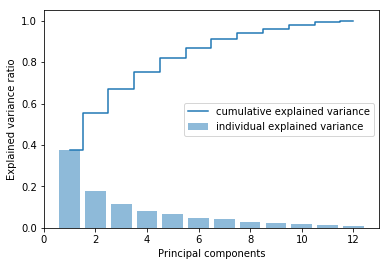

In [11]:
tot = sum(eigen_values)
var_exp = [(i / tot) for i in sorted(eigen_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

bar(range(1,13), var_exp, alpha=0.5, align='center',
                  label='individual explained variance')
step(range(1,13), cum_var_exp, where='mid',
                  label='cumulative explained variance')
ylabel('Explained variance ratio')
xlabel('Principal components')
legend(loc='best')
show()

# The plot shows that the first principal component alone accounts for 40 percent of the variance. Also, we can see that the first two principal components combined explain almost 60 percent of the variance in the data.

# Now that we have decomposed the covariance matrix into eigen-pairs, we want to transform the Wine dataset onto the new principal component axes.

# We're going to sort the eigen-pairs by descending order of the eigenvalues, and construct a projection matrix from the selected eigenvectors. Then, using the projection matrix we will transform the data onto the lower-dimensional subspace.

# Let's start by sorting the eigen-pairs by decreasing order of the eigenvalues:

In [12]:
eigen_pairs = \
[(np.abs(eigen_values[i]),eigen_vectors[:,i]) for i in range(len(eigen_values))]
eigen_pairs.sort(reverse=True)

In [13]:
eigen_pairs[:5]

[(4.549278092609497,
  array([ 0.09792557, -0.26822949, -0.05636465, -0.2490876 ,  0.10381074,
          0.39394193,  0.43611681, -0.31909159,  0.31749985, -0.15722763,
          0.33271752,  0.39878573])),
 (2.1451713248969586,
  array([-0.55155916, -0.23465793, -0.32926095,  0.07767497, -0.28539513,
         -0.19857326, -0.11274755,  0.0502997 , -0.1295819 , -0.55009847,
          0.24975316,  0.09149724])),
 (1.4119619915931652,
  array([ 0.17300132, -0.12328779, -0.63879713, -0.60328481, -0.04057581,
         -0.14671331, -0.11718713, -0.20079884, -0.12060856,  0.19628877,
         -0.12319014, -0.19334068])),
 (1.0095793915332574,
  array([-0.22132113, -0.15860876,  0.00244705,  0.10817557,  0.83226702,
         -0.21010011, -0.15313944, -0.31872026,  0.08246246, -0.09976201,
          0.00296354, -0.18853708])),
 (0.8120489484987332,
  array([-0.30896797,  0.58071121, -0.30981836,  0.01006501, -0.00272456,
          0.08468641,  0.04583936, -0.02962086,  0.57835453, -0.07230968,

# Next, we collect the two eigenvectors that correspond to the two largest values to capture about 60 percent of the variance in this dataset.

# Note that choosing the number of principal components has to be determined from a trade-off between computational efficiency and the performance of the classifier, however, we only chose two eigenvectors for the demonstration purpose.

In [14]:
w= np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
w.shape

(12, 2)

In [15]:
w

array([[ 0.09792557, -0.55155916],
       [-0.26822949, -0.23465793],
       [-0.05636465, -0.32926095],
       [-0.2490876 ,  0.07767497],
       [ 0.10381074, -0.28539513],
       [ 0.39394193, -0.19857326],
       [ 0.43611681, -0.11274755],
       [-0.31909159,  0.0502997 ],
       [ 0.31749985, -0.1295819 ],
       [-0.15722763, -0.55009847],
       [ 0.33271752,  0.24975316],
       [ 0.39878573,  0.09149724]])

# Now we've created a 13 × 2 projection matrix W from the top two eigenvectors. Using the projection matrix, we can now transform a sample x  (represented as 1 × 13 row vector) onto the PCA subspace obtaining x′ which is a 2-D sample vector consisting of two new features.

In [16]:
X_train_std[0]

array([ 0.91083058, -0.46259897, -0.01142613, -0.82067872,  0.06241693,
        0.58820446,  0.93565436, -0.7619138 ,  0.13007174, -0.51238741,
        0.65706596,  1.94354495])

In [17]:
X_train_std[0].dot(w)

array([ 2.42324861, -0.1252985 ])

# In the same way, we can transform the entire 124 × 13 training dataset onto the two principal components by calculating the matrix dot product.

In [18]:
X_train_pca = X_train_std.dot(w)
X_train_std.shape, w.shape, X_train_pca.shape

((124, 12), (12, 2), (124, 2))

# Finally, it's time to visualize the transformed Wine training set, now stored as an 124 × 2 matrix, in a two-dimensional scatterplot.

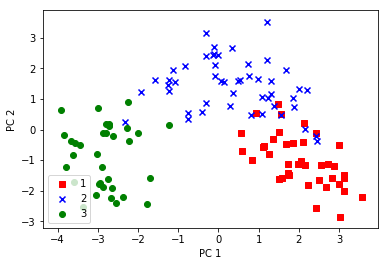

In [19]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1],
            c=c, label=l, marker=m)
xlabel('PC 1')
ylabel('PC 2')
legend(loc='lower left')
show()

# We we can see from the plot, the data is more spread along the x-axis which is the first principal component than the y-axis which is the second principal component.

# Though this is consistent with the explained variance ratio plot that we created in the previous subsection, we can intuitively see that a linear classifier will likely be able to separate the classes well.

# Doing the same thing with Scikit Learn where we first fit the model using the training data before we transform both the training data and the test data using the same model parameters.

# Let's use the PCA from scikit-learn on the Wine training dataset, and classify the transformed samples via logistic regression.

In [20]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    xlim(xx1.min(), xx1.max())
    ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx),
                marker=markers[idx], label=cl)

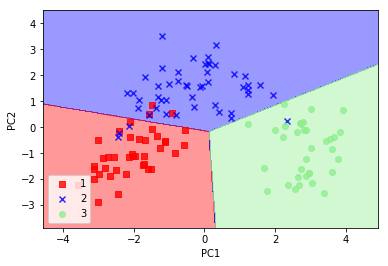

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
xlabel('PC1')
ylabel('PC2')
legend(loc='lower left')
show()